<center>
<h1 style = "text-align:center; font-style:bold;">
    Winter Term Project 2024
</h1>
</center> 

<center>
<h1 style="color:red;">
Momentum Trading technique with Machine Learning
</h1>
</center> 
    
<h6 style="text-align:center; font-style:italic;">Tobi Bui</h6>

<center>
<h1 style = "text-align:center; font-style:bold; color:red">
    Libraries
</h1>
</center> 

In [1]:
# Data Analysis Library
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from __future__ import division
import datetime
from datetime import date
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import itertools
import yfinance as yf
import ipywidgets as widgets

# Machine Learning Library
from sklearn import svm,neighbors, metrics, model_selection
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score, log_loss, f1_score


<center>
<h1 style = "text-align:center; font-style:bold; color:red">
    Data Collection
</h1>
</center> 

In [2]:
# Start and end dates  
start_date = datetime.datetime(2010, 1, 1)  
end_date = date.today().strftime('%Y-%m-%d')

# Download the quotes
def get_quotes(tickers, start_date, end_date):
    df_dict = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        df_dict[ticker] = df
        
    full_df = pd.concat(df_dict)
    
    return full_df

# Get the data 
tickers = ['AMZN', 'AAPL', 'GOOG', 'META', 'NFLX', 'MSFT', 'TSLA']
all_data = get_quotes(tickers, start_date, end_date)

# Query by date  
all_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
     Date                                                                     
AMZN 2010-01-04    6.812500    6.830500    6.657000    6.695000    6.695000   
     2010-01-05    6.671500    6.774000    6.590500    6.734500    6.734500   
     2010-01-06    6.730000    6.736500    6.582500    6.612500    6.612500   
     2010-01-07    6.600500    6.616000    6.440000    6.500000    6.500000   
     2010-01-08    6.528000    6.684000    6.451500    6.676000    6.676000   
...                     ...         ...         ...         ...         ...   
TSLA 2024-01-25  189.699997  193.000000  180.059998  182.630005  182.630005   
     2024-01-26  185.500000  186.779999  182.100006  183.250000  183.250000   
     2024-01-29  185.630005  191.479996  183.669998  190.929993  190.929993   
     2024-01-30  195.330002  196.360001  190.610001  191.589996  191.589996   
     2024-01-31  187.000000  193.970001  185.850006  187.289993  187.289993   

                    Volume  
     Date                   
AMZN 2010-01-04  151998000  
     2010-01-05  177038000  
     2010-01-06  143576000  
     2010-01-07  220604000  
     2010-01-08  196610000  
...                    ...  
TSLA 2024-01-25  198076800  
     2024-01-26  107063400  
     2024-01-29  125013100  
     2024-01-30  109982300  
     2024-01-31  103221400  

[24080 rows x 6 columns]

<center>
<h1 style = "text-align:center; font-style:bold; color:red">
    Creating Signals and Technical Indicators
</h1>
</center> 

In [3]:
# Initialize the `signals` DataFrame with the `signal` column
all_data['signal'] = 0.0

# Create short simple moving average over the short window
all_data['short_mavg'] = all_data['Adj Close'].rolling(window=30, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
all_data['long_mavg'] = all_data['Adj Close'].rolling(window=120, min_periods=1, center=False).mean()

# Create signals
all_data['signal'] = np.where(all_data['short_mavg'] > all_data['long_mavg'], 1.0, 0.0)

#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Adj Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
all_data['EMA21'] = EMA(all_data, 21)
all_data['EMA63'] = EMA(all_data, 63)
all_data['EMA252'] = EMA(all_data, 252)
all_data.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
all_data['ROC21'] = ROC(all_data['Adj Close'], 21)
all_data['ROC63'] = ROC(all_data['Adj Close'], 63)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
all_data['MOM21'] = MOM(all_data['Adj Close'], 21)
all_data['MOM63'] = MOM(all_data['Adj Close'], 63)

#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs=pd.DataFrame.ewm(u,com=period-1,adjust=False).mean() 
    pd.DataFrame.ewm(d,com=period-1,adjust=False).mean()
    return 100 - 100 / (1 + (rs))
all_data['RSI21'] = RSI(all_data['Adj Close'], 21)
all_data['RSI63'] = RSI(all_data['Adj Close'], 63)
all_data['RSI252'] = RSI(all_data['Adj Close'], 252)

#calculation of stochastic osillator.
def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).mean()) / (high.rolling(n).mean() - low.rolling(n).mean())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).mean()) / (high.rolling(n).mean() - low.rolling(n).mean())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD
all_data['%K21'] = STOK(all_data['Adj Close'], all_data['Low'], all_data['High'], 21)
all_data['%D21'] = STOD(all_data['Adj Close'], all_data['Low'], all_data['High'], 21)
all_data['%K63'] = STOK(all_data['Adj Close'], all_data['Low'], all_data['High'], 63)
all_data['%D63'] = STOD(all_data['Adj Close'], all_data['Low'], all_data['High'], 63)
all_data['%K252'] = STOK(all_data['Adj Close'], all_data['Low'], all_data['High'], 252)
all_data['%D252'] = STOD(all_data['Adj Close'], all_data['Low'], all_data['High'], 252)


#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Adj Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
all_data['MA21'] = MA(all_data, 21)
all_data['MA63'] = MA(all_data, 63)
all_data['MA252'] = MA(all_data, 252)

all_data

Open        High         Low       Close   Adj Close  \
     Date                                                                     
AMZN 2010-01-04    6.812500    6.830500    6.657000    6.695000    6.695000   
     2010-01-05    6.671500    6.774000    6.590500    6.734500    6.734500   
     2010-01-06    6.730000    6.736500    6.582500    6.612500    6.612500   
     2010-01-07    6.600500    6.616000    6.440000    6.500000    6.500000   
     2010-01-08    6.528000    6.684000    6.451500    6.676000    6.676000   
...                     ...         ...         ...         ...         ...   
TSLA 2024-01-25  189.699997  193.000000  180.059998  182.630005  182.630005   
     2024-01-26  185.500000  186.779999  182.100006  183.250000  183.250000   
     2024-01-29  185.630005  191.479996  183.669998  190.929993  190.929993   
     2024-01-30  195.330002  196.360001  190.610001  191.589996  191.589996   
     2024-01-31  187.000000  193.970001  185.850006  187.289993  187.289993   

                    Volume  signal  short_mavg   long_mavg       EMA21  ...  \
     Date                                                               ...   
AMZN 2010-01-04  151998000     0.0    6.695000    6.695000         NaN  ...   
     2010-01-05  177038000     0.0    6.714750    6.714750         NaN  ...   
     2010-01-06  143576000     0.0    6.680667    6.680667         NaN  ...   
     2010-01-07  220604000     0.0    6.635500    6.635500         NaN  ...   
     2010-01-08  196610000     0.0    6.643600    6.643600         NaN  ...   
...                    ...     ...         ...         ...         ...  ...   
TSLA 2024-01-25  198076800     0.0  234.990666  239.138166  221.973077  ...   
     2024-01-26  107063400     0.0  233.198666  238.549750  218.452797  ...   
     2024-01-29  125013100     0.0  231.586666  238.045416  215.950724  ...   
     2024-01-30  109982300     0.0  229.604666  237.561166  213.736113  ...   
     2024-01-31  103221400     0.0  227.397666  237.103666  211.331920  ...   

                    RSI252        %K21        %D21        %K63        %D63  \
     Date                                                                    
AMZN 2010-01-04        NaN         NaN         NaN         NaN         NaN   
     2010-01-05        NaN         NaN         NaN         NaN         NaN   
     2010-01-06        NaN         NaN         NaN         NaN         NaN   
     2010-01-07        NaN         NaN         NaN         NaN         NaN   
     2010-01-08        NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
TSLA 2024-01-25  73.775816 -584.395707 -399.467533 -527.305888 -327.441936   
     2024-01-26  73.715825 -531.927430 -472.955312 -517.437265 -427.414754   
     2024-01-29  73.848808 -375.947526 -497.423554 -423.610070 -489.451074   
     2024-01-30  73.789951 -342.217982 -416.697646 -413.534920 -451.527418   
     2024-01-31  73.712978 -360.395568 -359.520359 -470.625517 -435.923502   

                      %K252       %D252        MA21        MA63       MA252  
     Date                                                                    
AMZN 2010-01-04         NaN         NaN         NaN         NaN         NaN  
     2010-01-05         NaN         NaN         NaN         NaN         NaN  
     2010-01-06         NaN         NaN         NaN         NaN         NaN  
     2010-01-07         NaN         NaN         NaN         NaN         NaN  
     2010-01-08         NaN         NaN         NaN         NaN         NaN  
...                     ...         ...         ...         ...         ...  
TSLA 2024-01-25 -404.776414 -209.429948  228.828095  231.266190  223.385119  
     2024-01-26 -400.435428 -308.691593  225.334763  230.803174  223.539166  
     2024-01-29 -315.300713 -373.504185  221.977143  230.567778  223.660833  
     2024-01-30 -311.109929 -342.282024  219.044286  230.318412  223.715158  
     2024-01-31 

<ul>
    <li><strong>MA (Moving Average):</strong> The average of stock price. Used to identify the trend of the stock</li>
    <li><strong>Signals:</strong> Buy/Sell is based on Cross Over Strategy of simple short-term MA and long-term MA</li>
    <li><strong>EMA (Exponential MA):</strong> A type of MA that places a greater weight and significance on the most recent data points. Used in 21, 63, 252 days to determine trends</li>
    <li><strong>ROC (Rate of Change):</strong> The change in the value of a variable during a given period with respect to the old value. Used in 21, 63 days to understand the change amount a stock’s price.</li>
    <li><strong>MOM (Momentum):</strong> The rate of acceleration of a stock's price—that is, the speed at which the price is changing. Used in 21, 63 days to understand the momentum of a stock’s price.</li>
    <li><strong>RSI (Relative Strength Index):</strong> Measurement of the speed and magnitude of a stock's recent price changes to evaluate overvalued or undervalued conditions in the price of that security. Used in 21, 63, 252 days to indicate securities that may be primed for a trend reversal (up/down) or corrective pullback (stable) in price</li>
    <li>
        <strong>Stochastics oscilators:</strong>
        <ul>
            <li><strong>%K:</strong> the current price of the security, shown as a percentage of the difference between its highest and lowest point over the time the oscillator is being used (21, 63, 252 days).</li>
            <li><strong>%D:</strong> a 3-day average of %K: used to show whether the current trend is continuing or changing.</li>
        </ul>
    </li>
</ul>


<center>
<h1 style = "text-align:center; font-style:bold; color:red">
    Cleaning dataframe
</h1>
</center> 

In [4]:
datasub= all_data.dropna()
datasub.isnull().sum()
datasubs=datasub.drop(['Close','High','Low','Open', 'Volume','short_mavg','long_mavg','Adj Close'], axis=1)
datasubs

signal       EMA21       EMA63      EMA252      ROC21  \
     Date                                                                
AMZN 2011-01-04     1.0    8.995523    8.499302    7.473595   3.909009   
     2011-01-05     1.0    9.029657    8.526551    7.490879   6.024781   
     2011-01-06     1.0    9.053598    8.550510    7.507274   5.428559   
     2011-01-07     1.0    9.073680    8.573141    7.523333   6.085211   
     2011-01-10     1.0    9.088254    8.593799    7.538860   5.158866   
...                 ...         ...         ...         ...        ...   
TSLA 2024-01-25     0.0  221.973077  232.797719  231.258458 -28.829736   
     2024-01-26     0.0  218.452797  231.249353  230.878944 -29.907436   
     2024-01-29     0.0  215.950724  229.989373  230.563142 -24.587251   
     2024-01-30     0.0  213.736113  228.789392  230.255054 -22.895203   
     2024-01-31     0.0  211.331920  227.492536  229.915409 -24.607522   

                     ROC63      MOM21      MOM63      RSI21      RSI63  \
     Date                                                                
AMZN 2011-01-04  19.054051   0.466499   1.207000   5.852442   6.050482   
     2011-01-05  19.933453   0.468500   1.601000   6.098035   6.129013   
     2011-01-06  19.485696   0.454500   1.479500   5.824566   6.037601   
     2011-01-07  21.211522   0.460000   1.497000   5.562635   5.947465   
     2011-01-10  18.021477   0.491500   1.582500   5.311818   5.858592   
...                    ...        ...        ...        ...        ...   
TSLA 2024-01-25 -14.024100 -69.909988 -33.889999  55.536792  67.823563   
     2024-01-26 -10.939928 -73.359985 -29.169998  54.936594  67.577179   
     2024-01-29  -7.896773 -70.510010 -14.830002  60.423582  68.484767   
     2024-01-30  -2.923594 -61.589996 -15.710007  59.766376  68.244410   
     2024-01-31  -6.746666 -61.190002 -10.070007  58.587776  67.896652   

                    RSI252        %K21        %D21        %K63        %D63  \
     Date                                                                    
AMZN 2011-01-04   5.542182  202.156534  160.024849  420.595036  382.701871   
     2011-01-05   5.564067  261.810267  220.270023  475.417192  435.604915   
     2011-01-06   5.543211  211.232546  225.066449  425.287136  440.433121   
     2011-01-07   5.522429  182.445950  218.496255  400.863117  433.855815   
     2011-01-10   5.501721  148.712813  180.797103  369.779998  398.643417   
...                    ...         ...         ...         ...         ...   
TSLA 2024-01-25  73.775816 -584.395707 -399.467533 -527.305888 -327.441936   
     2024-01-26  73.715825 -531.927430 -472.955312 -517.437265 -427.414754   
     2024-01-29  73.848808 -375.947526 -497.423554 -423.610070 -489.451074   
     2024-01-30  73.789951 -342.217982 -416.697646 -413.534920 -451.527418   
     2024-01-31  73.712978 -360.395568 -359.520359 -470.625517 -435.923502   

                       %K252        %D252        MA21        MA63       MA252  
     Date                                                                      
AMZN 2011-01-04  1215.047939  1171.528956    8.987929    8.530349    6.976988  
     2011-01-05  1270.851134  1228.784987    9.010238    8.555762    6.987935  
     2011-01-06  1227.030897  1237.643324    9.031881    8.579246    6.999018  
     2011-01-07  1211.959569  1236.613867    9.053786    8.603008    7.009329  
     2011-01-10  1186.841488  1208.610652    9.077190    8.628127    7.020117  
...                      ...          ...         ...         ...         ...  
TSLA 2024-01-25  -404.776414  -209.429948  228.828095  231.266190  223.385119  
     2024-01-26  -400.435428  -308.691593  225.334763  230.803174  223.539166  
     2024-01-29  -315.300713  -373.504185  221.977143  230.567778  223.660833  
     2024-01-30  -311.109929  -342.282024  219.044286  230.318412  223.715158  
     2024-01-31  -361.382092  -329.264245  216.130476  230.158571  223.797023  

[23827 rows x 20 columns]

<center>
<h1 style = "text-align:center; font-style:bold; color:red">
    Feature Selection
</h1>
</center> 

<p>
  The process of selecting a subset of features that are most relevant for model construction aids in creating an accurate predictive model.
</p>

<p>
  Use the filter method utilizing the <code>random.forest.importance</code> function.
</p>

<ul>
  <li>Rates the importance of each feature in the classification of the outcome, i.e., class variable.</li>
  <li>Returns results based on the mean decrease in accuracy.</li>
</ul>


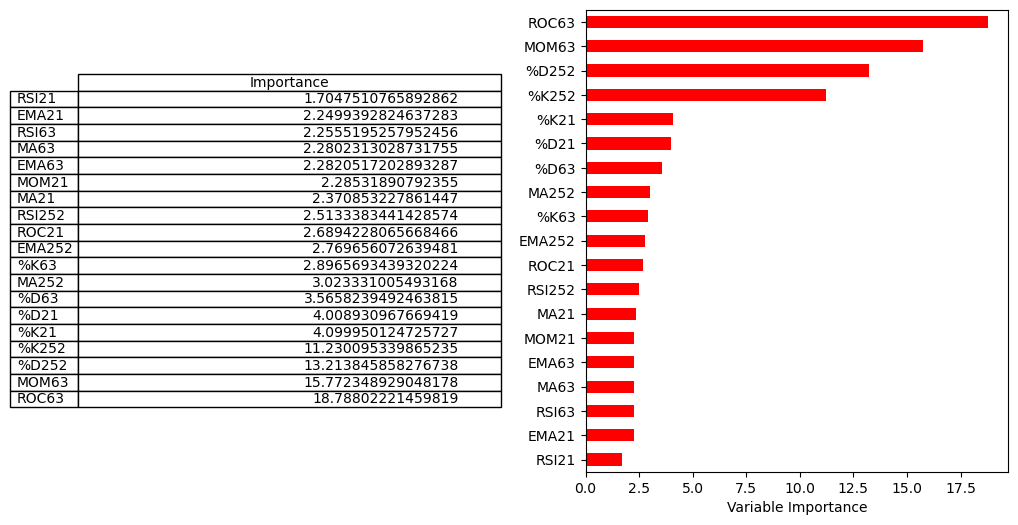

In [5]:
import matplotlib.pyplot as plt

X = datasubs.drop(['signal'], axis=1)
y = datasubs['signal']
forest = RandomForestClassifier(n_estimators=500, random_state=1, n_jobs=-1)
forest.fit(X, y)

importance = pd.DataFrame({'Importance': forest.feature_importances_ * 100}, index=X.columns)
sorted_importance = importance.sort_values('Importance', axis=0, ascending=True)

# Display results and graph side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display results
ax1.axis('off')
ax1.table(cellText=sorted_importance.values, colLabels=['Importance'], rowLabels=sorted_importance.index, loc='center')

# Display graph
sorted_importance.plot(kind='barh', color='r', ax=ax2)
ax2.set_xlabel('Variable Importance')
ax2.legend().set_visible(False)

plt.show()


<center>
<h1 style = "text-align:center; font-style:bold; color:red">
    Processing Training and Testing dataset
</h1>
</center> 

In [6]:
X_1=datasub.drop(['signal'],axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_1, y, test_size=0.2, random_state= 1)

from sklearn.preprocessing import RobustScaler
X_train_1=X_train.drop(['Close','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)
X_test_1=X_test.drop(['Close','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)

rs = RobustScaler()
rs.fit(X_train_1)
X_train_std = rs.transform(X_train_1)
X_test_std = rs.transform(X_test_1)

<p>
  <strong>Training/Testing Dataset:</strong> Split in an 80/20 ratio.
</p>

<p>
  <strong>Standardizing values using RobustScaler on normal distribution:</strong>
</p>

<ul>
  <li>
    Data often consists of many input variables or features (columns), each with a different range of values.
  </li>
  <li>
    Avoid biases in machine learning, where large values dominate smaller ones, by scaling the values to have a mean of zero and a standard deviation of one.
  </li>
  <li>
    Use Robust Scaler to ignore outliers, as this can change how the machine understands trends and makes decisions.
  </li>
</ul>


<center>
<h1 style = "text-align:center; font-style:bold; color:red">
    Choosing optimal ML Algorithms
</h1>
</center> 

<p>
  <strong>Choosing validation method: K-fold Cross Validation:</strong>
</p>

<ul>
  <li>
    The training dataset is trained k times, each time using k-1 folds for training and 1 for testing. 
  </li>
  <li>
    This process is repeated k times, with a different fold used for testing in each iteration. 
  </li>
  <li>
    The final performance metric (mean and standard deviation) is the average of the metric obtained in each iteration via cross-validation
  </li>
</ul>

In [7]:
# Spot Check Algorithms
data_Selected = []
data_Selected.append(('KNN', KNeighborsClassifier()))
data_Selected.append(('CART', DecisionTreeClassifier()))
data_Selected.append(('SVM', SVC()))
data_Selected.append(('RF', RandomForestClassifier()))
data_Selected.append(('NB', GaussianNB()))

# evaluate each model in turn
results = []
names = []
score=['f1','accuracy','precison','recall']
for name, model in data_Selected:
    kfold = model_selection.KFold(n_splits=10, random_state= 42, shuffle = True)
    cv_results =cross_val_score(model, X_train_std, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    output = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(output)

KNN: 0.946435 (0.005816)
CART: 0.933162 (0.004395)
SVM: 0.912491 (0.006665)
RF: 0.973191 (0.004828)
NB: 0.742197 (0.008736)


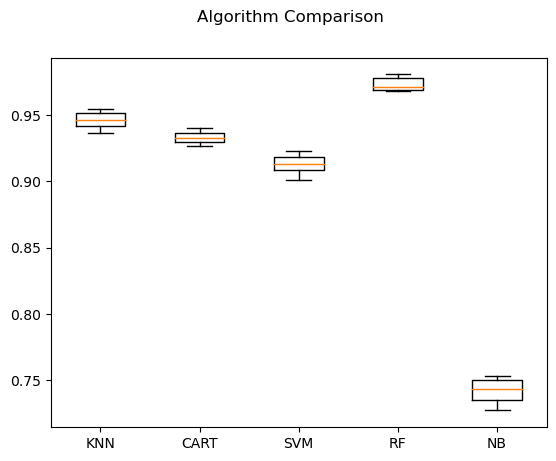

In [8]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<p><strong>Interpreting Results:</strong></p>
<ul>
    <li><strong>Mean Accuracy:</strong> Represents the average performance of the model over all folds. A higher mean accuracy suggests the model is better.</li>
    <li><strong>Standard Deviation:</strong> Indicates the variability or consistency of the model's performance. A lower standard deviation suggests more consistent results.</li>
</ul>


<center>
<h1 style = "text-align:center; font-style:bold; color:red">
    Winner: Ramdom Forest Classifier
</h1>
</center> 

<h2>Finetuning Hyperparameters</h2>
    <ul>
        <li><strong>n_estimators:</strong> The number of trees (500) in the forest.</li>
        <li><strong>min_samples_split:</strong> The minimum number of samples required to split an internal node. If the number of samples is less than this value, the node will not split.</li>
        <li><strong>min_samples_leaf:</strong> The minimum number of samples required to be at a leaf node. Leaf nodes are the final nodes in the tree, and a smaller min_samples_leaf value can lead to more fine-grained splits.</li>
        <li><strong>max_features:</strong> The maximum number of features (columns) each tree can use for splitting a node.</li>
        <li><strong>n_jobs:</strong> Utilizes all available processors for parallel execution during the training process. -1 means using all.</li>
        <li><strong>criterion:</strong> The function to measure the quality of a split. 'gini' is the Gini impurity, a measure of how often a randomly chosen element would be incorrectly labeled.</li>
    </ul>

In [9]:
rf = RandomForestClassifier(n_estimators=500, min_samples_split= 5, min_samples_leaf = 2,max_features = 10, n_jobs= -1 ,criterion='gini')
predy=rf.fit(X_train_std, Y_train)
predr= rf.predict(X_test_std)

print(accuracy_score(Y_test, predr))
print(confusion_matrix(Y_test, predr))
print(classification_report(Y_test, predr))

0.9647503147293328
[[1437   94]
 [  74 3161]]
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94      1531
         1.0       0.97      0.98      0.97      3235

    accuracy                           0.96      4766
   macro avg       0.96      0.96      0.96      4766
weighted avg       0.96      0.96      0.96      4766



<h2>Interpreting Results after Training</h2>

  <p><strong>Precision:</strong> A measure of how many of the positive predictions made are correct (true positives).
    The formula for it is: True Positives / (True Positives + False Positives)</p>

  <p><strong>Recall:</strong> The ratio of correctly predicted positive observations to all actual positives.
    The formula for it is: True Positives / (True Positives + False Negatives)</p>

  <p><strong>F-1 Score:</strong> A measure combining both precision and recall. It is generally described as the harmonic
    mean of the two, providing a clear balance if there are significant differences between precision and recall.
  </p>

  <p><strong>Support:</strong> The number of occurrences of each label in Y_train.</p>

In [10]:
def pltcm(ax, y_test, y_pred, classes, title, th=0.7, cmap=plt.cm.Reds):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_test, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tickmarks = np.arange(len(classes))
    ax.set_xticks(tickmarks)
    ax.set_yticks(tickmarks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('Actual')
    ax.set_xlabel('Prediction')

def pltauc(ax, y_train, y_pred, y_test, y_tpred, th=0.7):

    y_predl = (y_pred>th).astype(int)
    y_tpredl  = (y_tpred>th).astype(int)

    fpr_tr, tpr_tr, _ = roc_curve(y_train,y_pred)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
    acc_tr = accuracy_score(y_train, y_predl)

    fpr_ts, tpr_ts, _ = roc_curve(y_test,y_tpred)
    roc_auc_ts = auc(fpr_ts, tpr_ts)
    acc_ts = accuracy_score(y_test, y_tpredl)

    ax.plot(fpr_tr, tpr_tr)
    ax.plot(fpr_ts, tpr_ts)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_tr, roc_auc_tr)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_ts, roc_auc_ts)
    ax.legend([train_text, test_text])

def result(es,threshold,X_train,X_test,y_train,y_test):
    y_pred = es.predict(X_train)
    y_tpred = es.predict(X_test)

    fig,ax = plt.subplots(1,3)
    fig.set_size_inches(15,5)
    pltcm(ax[0],  y_train, y_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
    pltcm(ax[1],  y_test, y_tpred,   [0,1], 'Confusion matrix (TEST)', threshold)
    pltauc(ax[2], y_train, y_pred, y_test, y_tpred, threshold)
    plt.tight_layout()
    plt.show()
    
def btf1(es,X_test,y_test):
    thresholds = np.linspace(0.3,0.6,100)
    y_tpred = es.predict(X_test)
    score_set = []
    index_threshold = 0
    sum_score = 0
    for threshold in thresholds:
        y_tpred1  = (y_tpred > threshold).astype(int)
        score = f1_score(y_test, y_tpred1)
        score_set.append(score)
    for i in range(95):
        temp = sum(score_set[i:i+5])
        if temp > sum_score:
            sum_score = temp
            index_threshold = i+2 # the average threshold
    return thresholds[index_threshold],sum_score/5

def testf1(es,bestthreshold,X_test,y_test):
    y_tpred = es.predict(X_test)
    y_tpred1  = (y_tpred > bestthreshold).astype(int)
    score = f1_score(y_test, y_tpred1)
    return score

test f1: 0.9741140215716487 train f1: 0.998555572449445


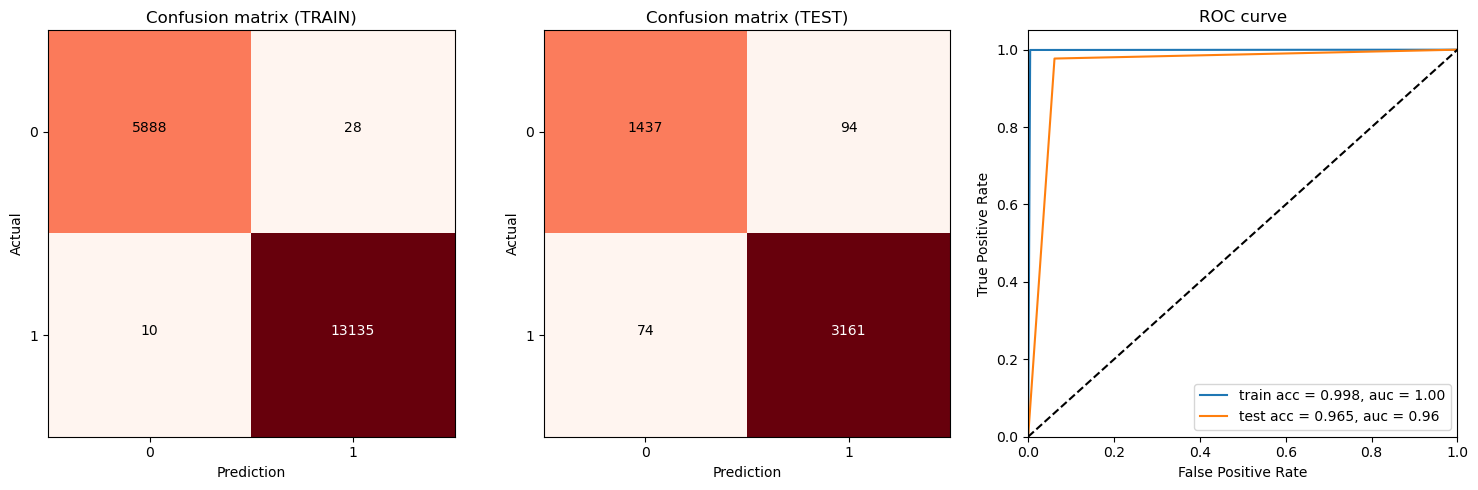

In [11]:
bestthreshold,bestf1 = btf1(rf,X_train_std, Y_train)
testf1 = testf1(rf,bestthreshold,X_test_std,Y_test)
print('test f1:',testf1,'train f1:',bestf1)
result(rf,bestthreshold,X_train_std,X_test_std, Y_train,Y_test)

<center>
<h1 style = "text-align:center; font-style:bold; color:red">
    Backtesting and Make some money
</h1>
</center> 

signal_pred  signal_actual  Market Returns  Actual Returns  \
     Date                                                                     
NFLX 2021-06-08          0.0            0.0             NaN             NaN   
GOOG 2010-07-27          0.0            0.0       -0.975081       -0.000000   
NFLX 2022-02-16          0.0            0.0       31.443991        0.000000   
AAPL 2011-10-24          1.0            1.0       -0.963596       -0.000000   
META 2017-12-26          1.0            1.0       11.144121       11.144121   
...                      ...            ...             ...             ...   
GOOG 2014-10-15          1.0            1.0       -0.909260       -0.909260   
     2019-06-17          0.0            0.0        1.066863        1.066863   
MSFT 2014-02-26          1.0            1.0       -0.314050       -0.000000   
TSLA 2018-07-17          1.0            1.0       -0.425870       -0.425870   
MSFT 2010-08-24          0.0            0.0        0.117481        0.117481   

                 Strategy Returns  
     Date                          
NFLX 2021-06-08               NaN  
GOOG 2010-07-27         -0.000000  
NFLX 2022-02-16          0.000000  
AAPL 2011-10-24         -0.000000  
META 2017-12-26         11.144121  
...                           ...  
GOOG 2014-10-15         -0.909260  
     2019-06-17          1.066863  
MSFT 2014-02-26         -0.000000  
TSLA 2018-07-17         -0.425870  
MSFT 2010-08-24          0.117481  

[4766 rows x 5 columns]

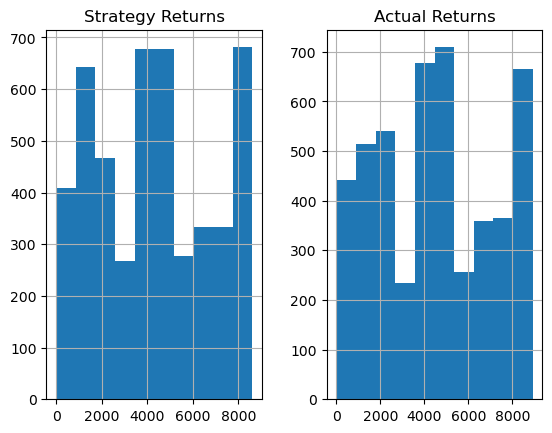

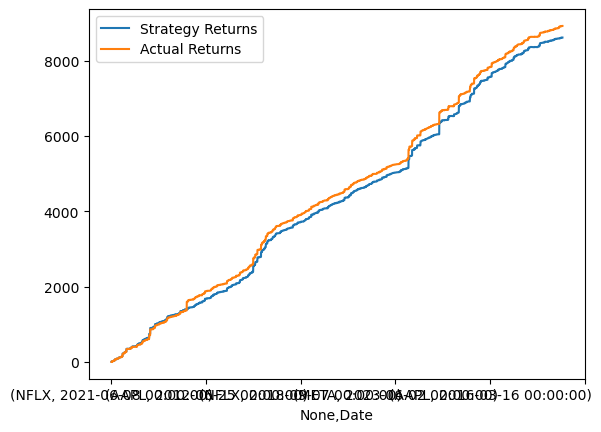

In [12]:

#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_test.index)
backtestdata['signal_pred'] = predr
backtestdata['signal_actual'] = Y_test
backtestdata['Market Returns'] = X_test['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()
backtestdata

<h2>Comparison of Returns Based on Test Data</h2>

  <p><strong>Strategy Return:</strong> Calculated as (Market Return * Predicted Signals) using the Cross Over Strategy.</p>

  <p><strong>Market Return:</strong> Determined based on changes in the adjusted close price after each day.</p>

  <p><strong>Actual Return:</strong> Calculated as (Market Return * Signals from the Cross Over Strategy).</p>

<center>
<h1 style = "text-align:center; font-style:bold; color:red">
    Split dataset to customize each stocks
</h1>
</center> 

In [13]:
backtestdata = backtestdata.sort_index(level='Date')
backtestdata.index.names = ['Stock', 'Date']
grouped = backtestdata.groupby(level='Stock')

tickers = ['AMZN', 'AAPL', 'GOOG', 'META', 'NFLX', 'MSFT', 'TSLA']
aapl_df = grouped.get_group('AAPL')
amzn_df = grouped.get_group('AMZN')
goog_df = grouped.get_group('GOOG')
meta_df = grouped.get_group('META')
nflx_df = grouped.get_group('NFLX')
msft_df = grouped.get_group('MSFT')
tsla_df = grouped.get_group('TSLA')


# create 7 output widgets
aapl_output = widgets.Output()
amzn_output = widgets.Output()
goog_output = widgets.Output()
meta_output = widgets.Output()
nflx_output = widgets.Output()
msft_output = widgets.Output()
tsla_output = widgets.Output()

# display the dataframes side by side
with aapl_output:
    display(aapl_df)
with amzn_output:
    display(amzn_df)
with goog_output:
    display(goog_df)
with meta_output:
    display(meta_df)
with msft_output:
    display(msft_df)
with nflx_output:
    display(nflx_df)
with tsla_output:
    display(tsla_df)


# display result
widgets.HBox([aapl_output, amzn_output, goog_output, meta_output, nflx_output, msft_output, tsla_output])

<center>
<h1 style = "text-align:center; font-style:bold; color:red">
    Custom Investment Graph for each stock
</h1>
</center> 

In [44]:
stock_symbols = ['AMZN', 'AAPL', 'GOOG', 'META', 'NFLX', 'MSFT', 'TSLA']

# Create a dictionary to store DataFrames and their corresponding stock symbols
dataframes = {}

# Loop through the stock symbols
for symbol in stock_symbols:
    # Get the adjusted close prices from all_data
    adj_close = all_data.loc[symbol]['Adj Close'].reindex(locals()[f'{symbol.lower()}_df'].index.get_level_values(1))
    
    # Reset index and update 'Adj Close' column for the DataFrame
    df = locals()[f'{symbol.lower()}_df'].reset_index(level='Stock', drop=True)
    df.loc[:, 'Adj Close'] = adj_close
    
    # Store the DataFrame in the dictionary
    dataframes[symbol.lower()] = df


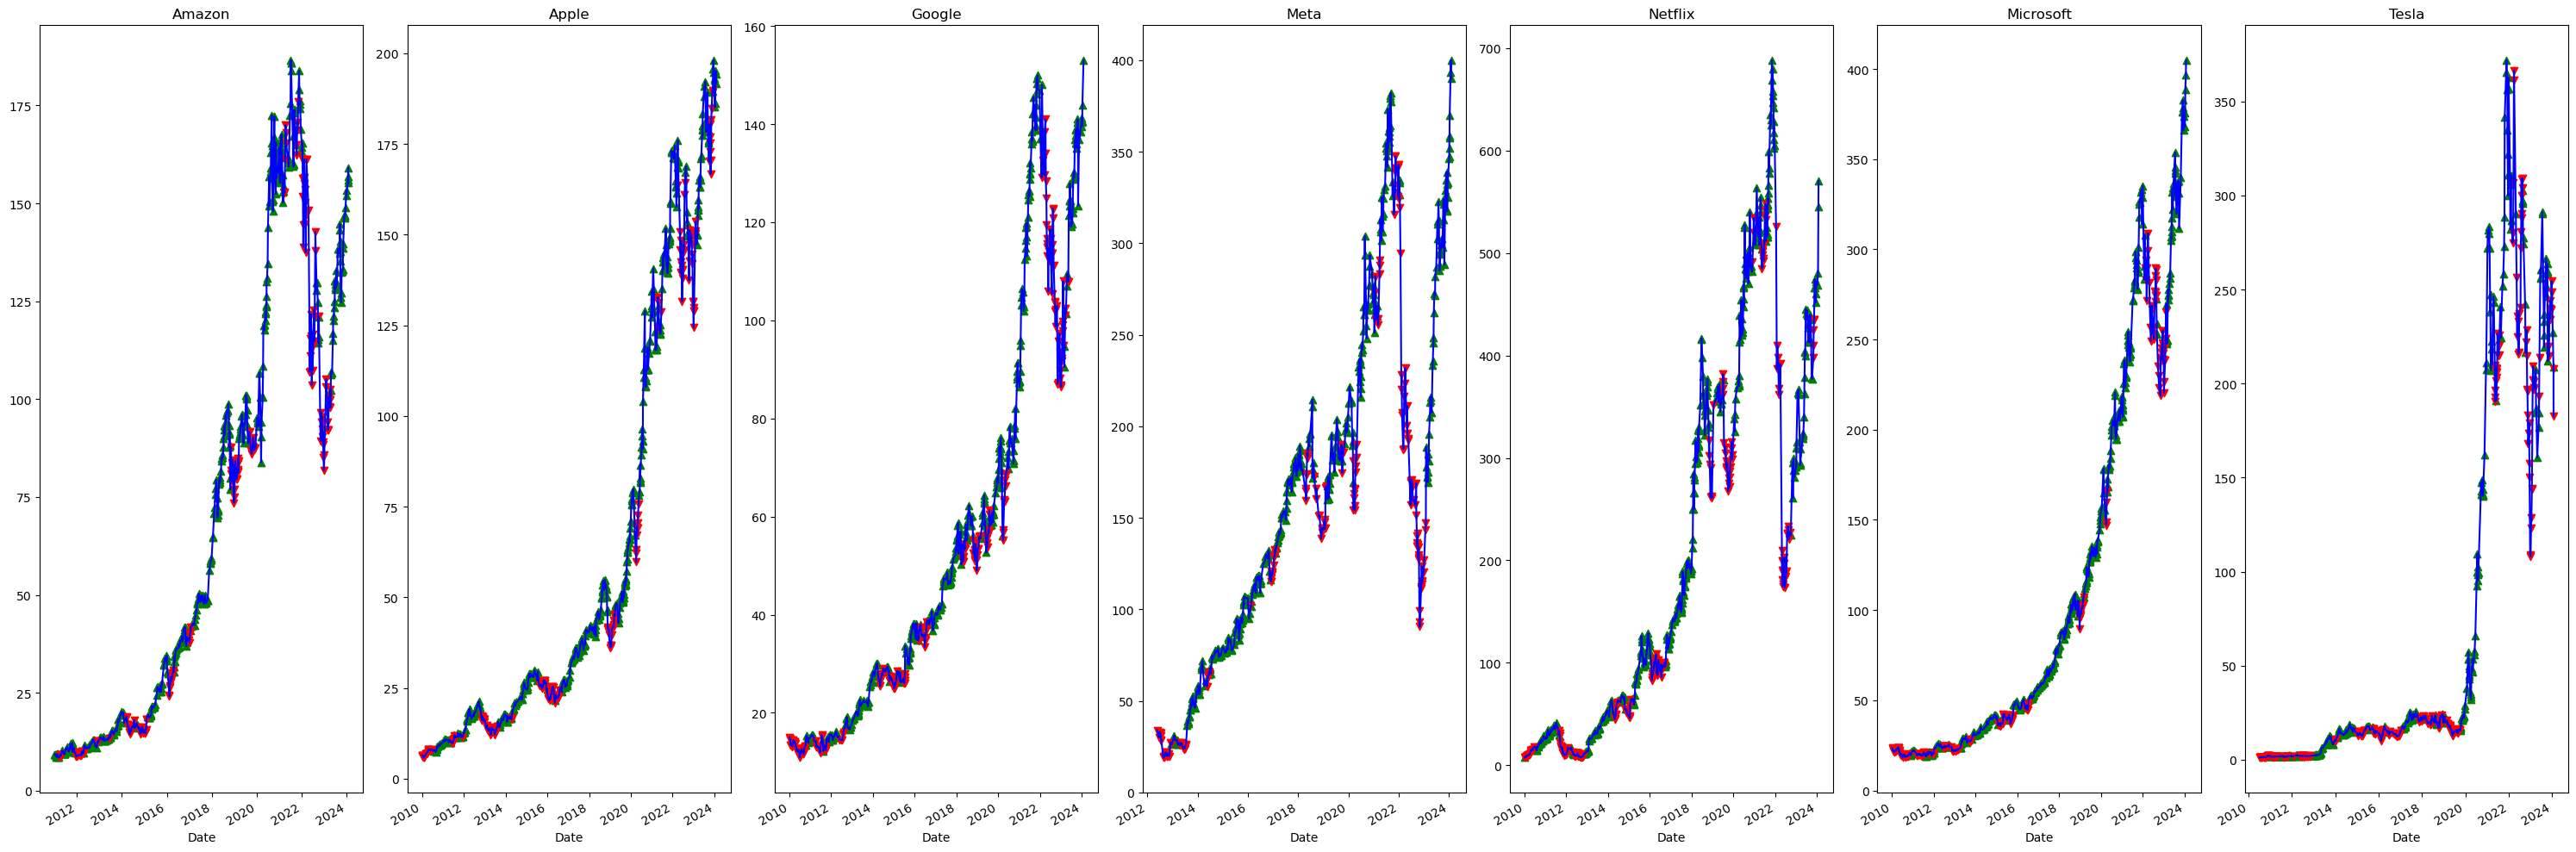

In [45]:
# Define the DataFrames and their titles in a dictionary
dataframes = {
    'Amazon': dataframes['amzn'],
    'Apple': dataframes['aapl'],
    'Google': dataframes['goog'],
    'Meta': dataframes['meta'],
    'Netflix': dataframes['nflx'],
    'Microsoft': dataframes['msft'],
    "Tesla": dataframes['tsla']
}

# Create subplots
fig, axs = plt.subplots(1, 7,figsize=(30, 10))

# Loop through the DataFrames and plot
for ax, (title, df) in zip(axs, dataframes.items()):
    df['Adj Close'].plot(ax=ax, color='b')
    
    # Identify signals 
    buys = df[df['signal_pred'] == 1].index
    sells = df[df['signal_pred'] == 0].index
    
    # Plot markers
    ax.scatter(buys, df.loc[buys, 'Adj Close'], marker='^', color='g')
    ax.scatter(sells, df.loc[sells, 'Adj Close'], marker='v', color='r')
    ax.set_title(title)
    
    cash = 100000  # Initial cash
    stocks = 0     # Initial stocks
    profit = 0     # Initial profit
    for index, row in df.iterrows():
        if row['signal_pred'] == 1:  # Buy signal
            # Buy stocks with available cash
            stocks += cash / row['Adj Close']
            cash = 0
        elif row['signal_pred'] == 0:  # Sell signal
            # Sell all stocks and get cash
            cash += stocks * row['Adj Close']
            stocks = 0
        
profit = cash + stocks * df['Adj Close'].iloc[-1] - 100000
plt.tight_layout()


In [46]:
profit

1466611.5017846234

In [ ]:
# Chat with an intelligent assistant in your terminal
from openai import OpenAI

# Point to the local server
client = OpenAI(base_url="http://localhost:1234/v1", api_key="not-needed")

history = [
    {"role": "system", "content": "You are an intelligent assistant. You always provide well-reasoned answers that are both correct and helpful."},
    {"role": "user", "content": "Hello, introduce yourself to someone opening this program for the first time. Be concise."},
]

done = True
while done:
    completion = client.chat.completions.create(
        model="local-model", # this field is currently unused
        messages=history,
        temperature=0.7,
        stream=True,
    )

    new_message = {"role": "assistant", "content": ""}|
    
    for chunk in completion:
        if chunk.choices[0].delta.content:
            print(chunk.choices[0].delta.content, end="", flush=True)
            new_message["content"] += chunk.choices[0].delta.content

    history.append(new_message)
    
    # Uncomment to see chat history
    # import json
    # gray_color = "\033[90m"
    # reset_color = "\033[0m"
    # print(f"{gray_color}\n{'-'*20} History dump {'-'*20}\n")
    # print(json.dumps(history, indent=2))
    # print(f"\n{'-'*55}\n{reset_color}")

    print()
    question = input("> ")
    if question != "> exit":
        history.append({"role": "user", "content": question})
    else:
        done = False